In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
from scipy.signal import detrend
import pandas as pd
import pickle

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

%load_ext autoreload
%autoreload 2

from pySSA.mySSA import mySSA
from tools.log_progress import log_progress

In [2]:
# load tides and no tides hourly melting over two month
file_path = os.path.join(raw_dir,'waom4_hr','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path)

file_path = os.path.join(raw_dir,'waom4_hr_nt','ocean_avg_0010.nc')
no_tides = xr.open_dataset(file_path)

# load grid
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

In [44]:
#subset region for testing purposes
rho_sel = {'xi_rho' : slice(250,400),'eta_rho' : slice(380,675)}

AM_nt = no_tides.isel(rho_sel)
AM_t = tides.isel(rho_sel)
AM_mask = (grd.mask_rho == 1 & (grd.zice<0)).sel(rho_sel)

#subset region for testing purposes
#rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,1000)}
rho_sel = {'eta_rho' : slice(606,1000)}
FRIS_nt = no_tides.isel(rho_sel)
FRIS_t = tides.isel(rho_sel)
FRIS_mask = (grd.mask_rho == 1 & (grd.zice<0)).sel(rho_sel)

In [3]:
#check that times are the same and sample length
print('start stop\n tides: ',tides.ocean_time.values[[0,-1]],'\n no_tides: ',no_tides.ocean_time.values[[0,-1]])
print('sample length in days: ',tides.ocean_time.size/24)

start stop
 tides:  ['2015-12-30T00:30:00.000000000' '2016-01-28T23:30:00.000000000'] 
 no_tides:  ['2015-12-30T00:30:00.000000000' '2016-01-28T23:30:00.000000000']
sample length in days:  30.0


In [4]:
#define function that give you the percent variance explained by frequencies below and above certain value
def get_var(ts_cell,K,j,i):
    
    if np.var(ts_cell.values) == 0.0:
        var_slow,var_fast,var_slow_contr,var_fast_contr = 0,0,0,0
        
    else:
        
        ts = ts_cell.copy()
        ts[:] = detrend(ts_cell.values,-1,'linear')
        ssa = mySSA(ts.to_dataframe()[ts.name])

        ssa.embed(embedding_dimension=K)
        ssa.decompose()
        
        try:
            slow_rho_idx = np.argmax(np.abs(ssa.U.sum(0))/(np.abs(ssa.U).sum(0)))
            fast_rho_idx = np.delete(range(K),slow_rho_idx)

            var_slow,var_slow_contr = ssa.s[slow_rho_idx],ssa.s_contributions.values[slow_rho_idx][0]
            var_fast,var_fast_contr = sum(np.delete(ssa.s,slow_rho_idx)),sum(np.delete(ssa.s_contributions.values.squeeze(),slow_rho_idx))
        
        except Exception as exc:
            print(f'\n eta: {j}, xi: {i}')
            print(exc)
            
            var_slow,var_slow_contr,var_fast,var_fast_contr = (np.nan,np.nan,np.nan,np.nan)
    
    
    return var_slow,var_slow_contr,var_fast,var_fast_contr

def get_var_map(ts_map,mask,K):
    
    var_map = np.tile(np.zeros_like(ts_map[0].values),(4,1,1))
    
    for j in log_progress(ts_map.eta_rho.values,name='eta'):
        if mask[j,:].any()==True:        
            for i in ts_map.xi_rho.values:           
                if (mask[j,i]==True):
                    if (ts_map[:,j,i].isnull().any()==False):
                        var_map[:,j,i] = get_var(ts_map[:,j,i],K,j,i)

                
    var = xr.Dataset({'total':(['eta_rho','xi_rho'],var_map[0]+var_map[2]),
                      'slow':(['eta_rho','xi_rho'],var_map[0]),
                      'slow_contr':(['eta_rho','xi_rho'],var_map[1]),
                      'fast':(['eta_rho','xi_rho'],var_map[2]),
                      'fast_contr':(['eta_rho','xi_rho'],var_map[3])}).where(mask)
    
    
    return var

In [59]:
pickle_in = open(os.path.join(int_dir,"var.pkl"),"rb")
var = pickle.load(pickle_in)

In [60]:
#convert to meter ice per year
s2a = 3600*24*365.25
for k in ['tides','no_tides']:
    var[k]['m']['total'] = var[k]['m']['total']*s2a**2

In [78]:
for k in ['tides','no_tides']:
    var[k]['ustar']['total'] = var[k]['ustar']['total']*100**2

In [76]:
%matplotlib notebook
#plot variances of raw, low pass and high pass filtered signals

def plot_var(var_nt,var_t,title,unit,save=False):
    
    dA = ((grd.pm*grd.pn)**-1).where((grd.mask_rho == 1) & (grd.zice<0))
    weights = dA / dA.sum()
    
    plt.close()
    fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(15,10))

    (var_nt.total).plot(ax=axes[0,0],cbar_kwargs={'label': f'var in {unit}'},vmax=var_t.total.mean()+var_t.total.std())
    #axes[0,0].text(0.5,-0.1, f'mean = {(var_nt.total*weights).sum().values:.3f} {unit}', size=12, ha="center", transform=axes[0,0].transAxes)
    
    (var_t.total).plot(ax=axes[0,1],cbar_kwargs={'label': f'var in {unit}'},vmax=var_t.total.mean()+var_t.total.std())
    #axes[0,1].text(0.5,-0.1, 'mean = %.3g'+unit%(var_t.total*weights).sum().values, size=12, ha="center", transform=axes[0,1].transAxes)
    
    ((var_t.total-var_nt.total)).plot(ax=axes[0,2],cmap='bwr',cbar_kwargs={'label': f'var in {unit}'},
                                      vmin = 0-var_t.total.std(),
                                      vmax = 0+var_t.total.std())
    #axes[0,2].text(0.5,-0.1, 'mean = %.3g'+unit%((var_t.total-var_nt.total)*weights).sum().values, size=12, ha="center", transform=axes[0,2].transAxes)

    var_nt.slow_contr.plot(ax=axes[1,0],cbar_kwargs={'label': f'var < 24h band in %'})
    #axes[1,0].text(0.5,-0.1, 'mean = %.3g'+unit%(var_nt.slow*weights).sum().values, size=12, ha="center", transform=axes[1,0].transAxes)
    
    var_t.slow_contr.plot(ax=axes[1,1],cbar_kwargs={'label': f'var < 24h band in %'})
    #axes[1,1].text(0.5,-0.1, 'mean = %.3g'+unit%(var_t.slow*weights).sum().values, size=12, ha="center", transform=axes[1,1].transAxes)
    
    ((var_t.slow_contr-var_nt.slow_contr)).plot(ax=axes[1,2],cbar_kwargs={'label': f'var < 24h band in %'})
    #axes[1,2].text(0.5,-0.1, 'mean = %.3g'+unit%((var_t.slow-var_nt.slow)*weights).sum().values, size=12, ha="center", transform=axes[1,2].transAxes)

    var_nt.fast_contr.plot(ax=axes[2,0],cbar_kwargs={'label': f'var > 24h band in %'})
    #axes[2,0].text(0.5,-0.1, 'mean = %.3g'+unit%(var_nt.fast*weights).sum().values, size=12, ha="center", transform=axes[2,0].transAxes)

    var_t.fast_contr.plot(ax=axes[2,1],cbar_kwargs={'label': f'var > 24h band in %'})    
    #axes[2,1].text(0.5,-0.1, 'mean = %.3g'+unit%(var_t.fast*weights).sum().values, size=12, ha="center", transform=axes[2,1].transAxes)

    ((var_t.fast_contr-var_nt.fast_contr)).plot(axes=axes[2,2],cbar_kwargs={'label': f'var > 24h band in %'})
    #axes[2,2].text(0.5,-0.1, 'mean = %.3g'+unit%((var_t.fast-var_nt.fast)*weights).sum().values, size=12, ha="center", transform=axes[2,2].transAxes)

    for ax in axes.flatten():
        ax.set_aspect('equal')
        ax.axis('off')

    cols = ['Without tides','With tides','Difference']
   # rows = ['var \n'+unit,'% var \n> 24h band','% var \n< 24h band']

    pad = 5 # in points

    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    #for ax, row in zip(axes[:,0], rows):
    #    ax.annotate(row, xy=(1, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
    #                xycoords=ax.yaxis.label, textcoords='offset points',
    #                size='large', ha='right', va='center')

    fig.tight_layout()

    fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
    
    if save:
        plt.savefig(os.path.join(fig_dir,'SSA_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=300,bbox_inches = "tight")    
    
    plt.show()


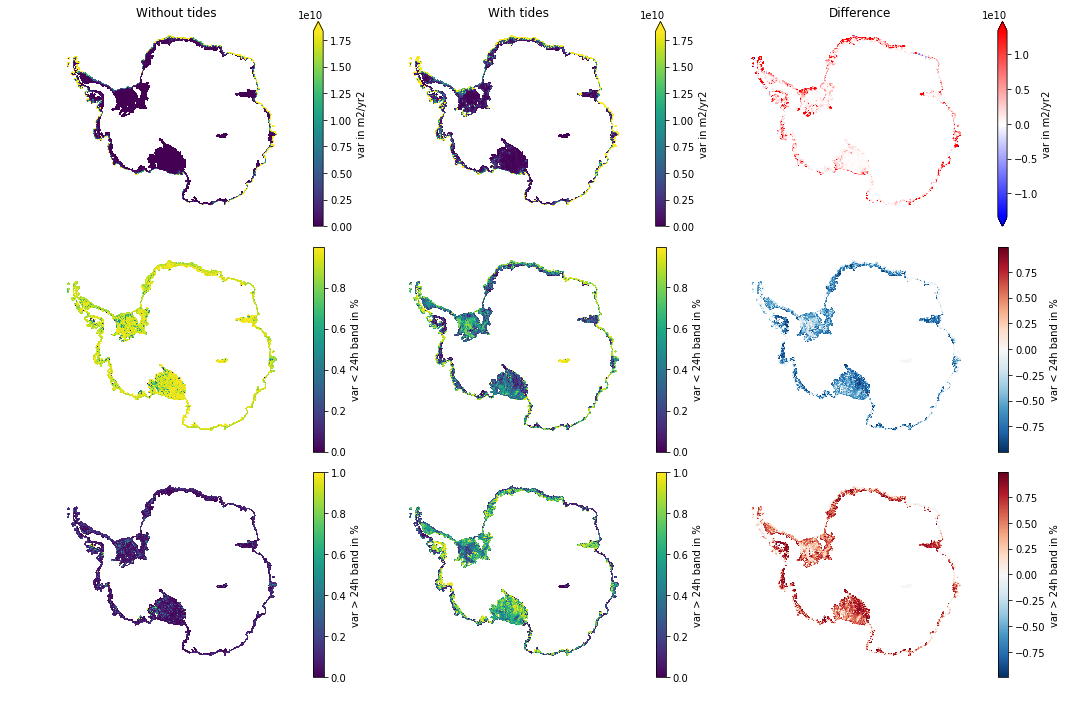

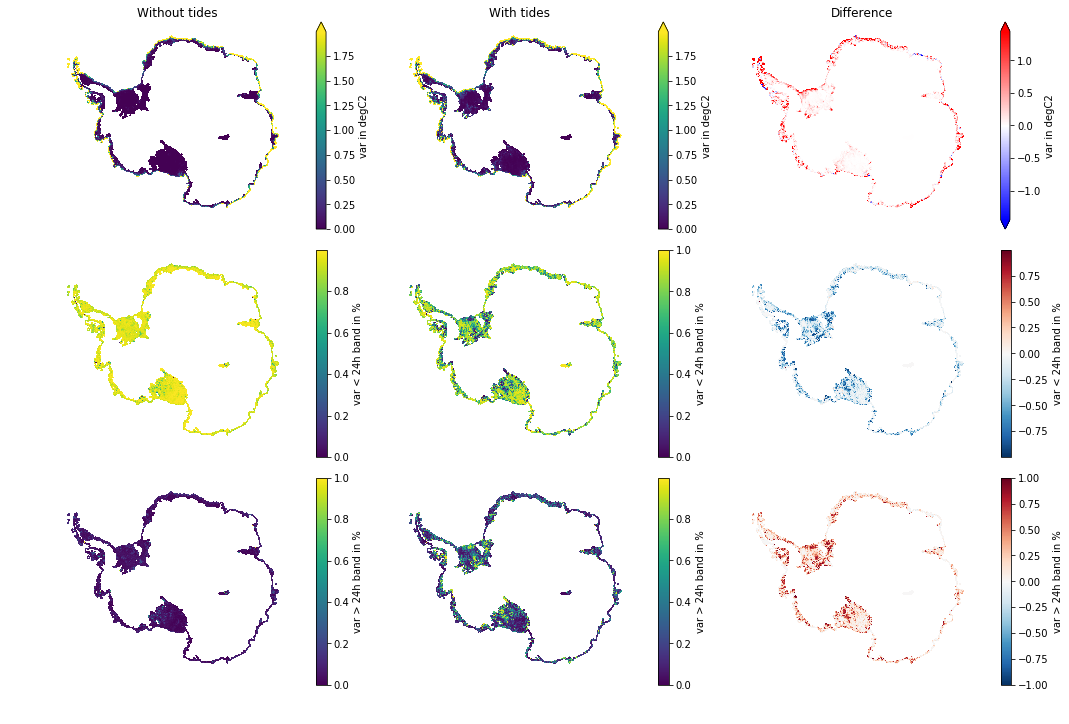

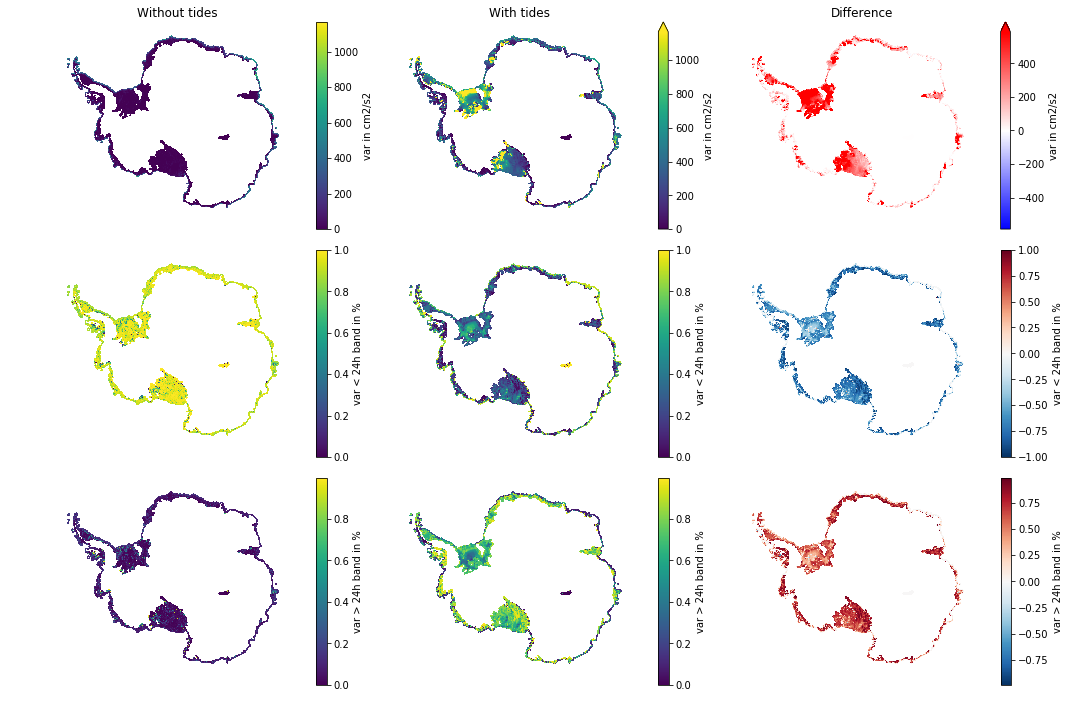

In [79]:
%matplotlib inline

plot_var(var['no_tides']['m'],var['tides']['m'],'ismr','m2/yr2',True)
plot_var(var['no_tides']['Tstar'],var['tides']['Tstar'],'Tstar','degC2',True)
plot_var(var['no_tides']['ustar'],var['tides']['ustar'],'ustar','cm2/s2',True)

<IPython.core.display.Javascript object>


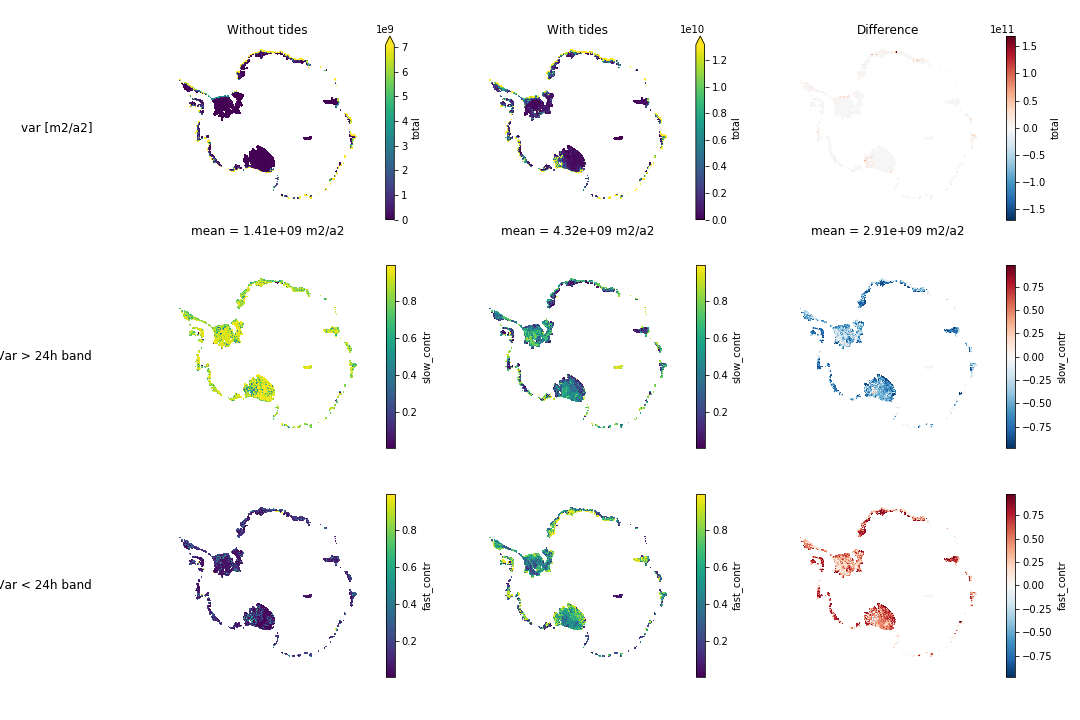

In [113]:
plot_var(var_nt,var_t*